In [1]:
import numpy as np
import cupy as cp
import pandas as pd
from hyperbolic_mf import HyperbolicMF, NegativeSampler
import matplotlib.pyplot as plt
from movie_utils import *

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
data_path = '/app/datasets/movielens1m/'

# Load data

In [4]:
def load_movies_data(path, moviedata_name):
    dataframe = {'id': [], 'title': [], 'genres': []}
    with open(path + moviedata_name, 'r') as f:
        for line in f:
            ident, name, genres = line.split('::')
            dataframe['id'].append(int(ident))
            dataframe['title'].append(name)
            dataframe['genres'].append(genres.split('|'))
    return pd.DataFrame(dataframe)

def load_ratings_data(path, rating_name):
    dataframe = {'userid': [], 'movieid': [], 'rating': [], 'timestamp': []}
    with open(path + rating_name, 'r') as f:
        for line in f:
            userid, movieid, rating, timestamp = line.split('::')
            dataframe['userid'].append(int(userid))
            dataframe['movieid'].append(int(movieid))
            dataframe['rating'].append(float(rating))
            dataframe['timestamp'].append(int(timestamp))
    return pd.DataFrame(dataframe)

def load_users_data(path, users_name):
    dataframe = {'userid': [], 'gender': [], 'age': [], 'occupation': [], 'zipcode': []}
    with open(path + users_name, 'r') as f:
        for line in f:
            userid, gender, age, occupation, zipcode = line.split('::')
            dataframe['userid'].append(int(userid))
            dataframe['gender'].append(0 if gennder == 'F' else 1)
            dataframe['age'].append(int(age))
            dataframe['occupation'].append(int(occupation))
            dataframe['zipcode'].append(int(zipcode))
    return pd.DataFrame(dataframe)

In [5]:
training_source = load_ratings_data(data_path, 'ratings.dat')
training_source

,userid,movieid,rating,timestamp
0,1,1193,5.0,978300760
1,1,661,3.0,978302109
2,1,914,3.0,978301968
3,1,3408,4.0,978300275
4,1,2355,5.0,978824291
...,...,...,...,...
1000204,6040,1091,1.0,956716541
1000205,6040,1094,5.0,956704887
1000206,6040,562,5.0,956704746
1000207,6040,1096,4.0,956715648


# Preprocessing

In [24]:
train_val, test_val, hold_val = timepoint_split(training_source, time_split_q=0.9)
train_val, test_val, hold_val, data_index = transform_data(train_val, test_val, hold_val)

In [25]:
data_description = {
    'users': 'userid',
    'items': 'movieid',
    'feedback': 'rating',
    'n_users': len(data_index['users'].unique()),
    'n_items': len(data_index['items'].unique())
}
data_description

{'users': 'userid',
 'items': 'movieid',
 'feedback': 'rating',
 'n_users': 4831,
 'n_items': 3635}

In [26]:
hold_val['movieid'].isin(train_val['movieid']).sum() / len(hold_val['movieid'])

1.0

In [27]:
test_val['userid'].isin(train_val['userid']).sum() / len(test_val['userid'])

0.8405949024579462

# Model training

In [22]:
train_interations, train_data = generate_interactions_matrix(train_val, data_description, False, backend=cp)
test_interations, test_data = generate_interactions_matrix(test_val, data_description, True, backend=cp)

model = HyperbolicMF(sigma_U=1e-2, sigma_V=1e-2, backend=cp)
losses, U_n, V_n = model.fit(train_interations, train_data, num_epochs=50, learning_rate=1e-4, decomposition_rank=10, batch_size=200)

  0%|          | 0/50 [00:00<?, ?it/s]

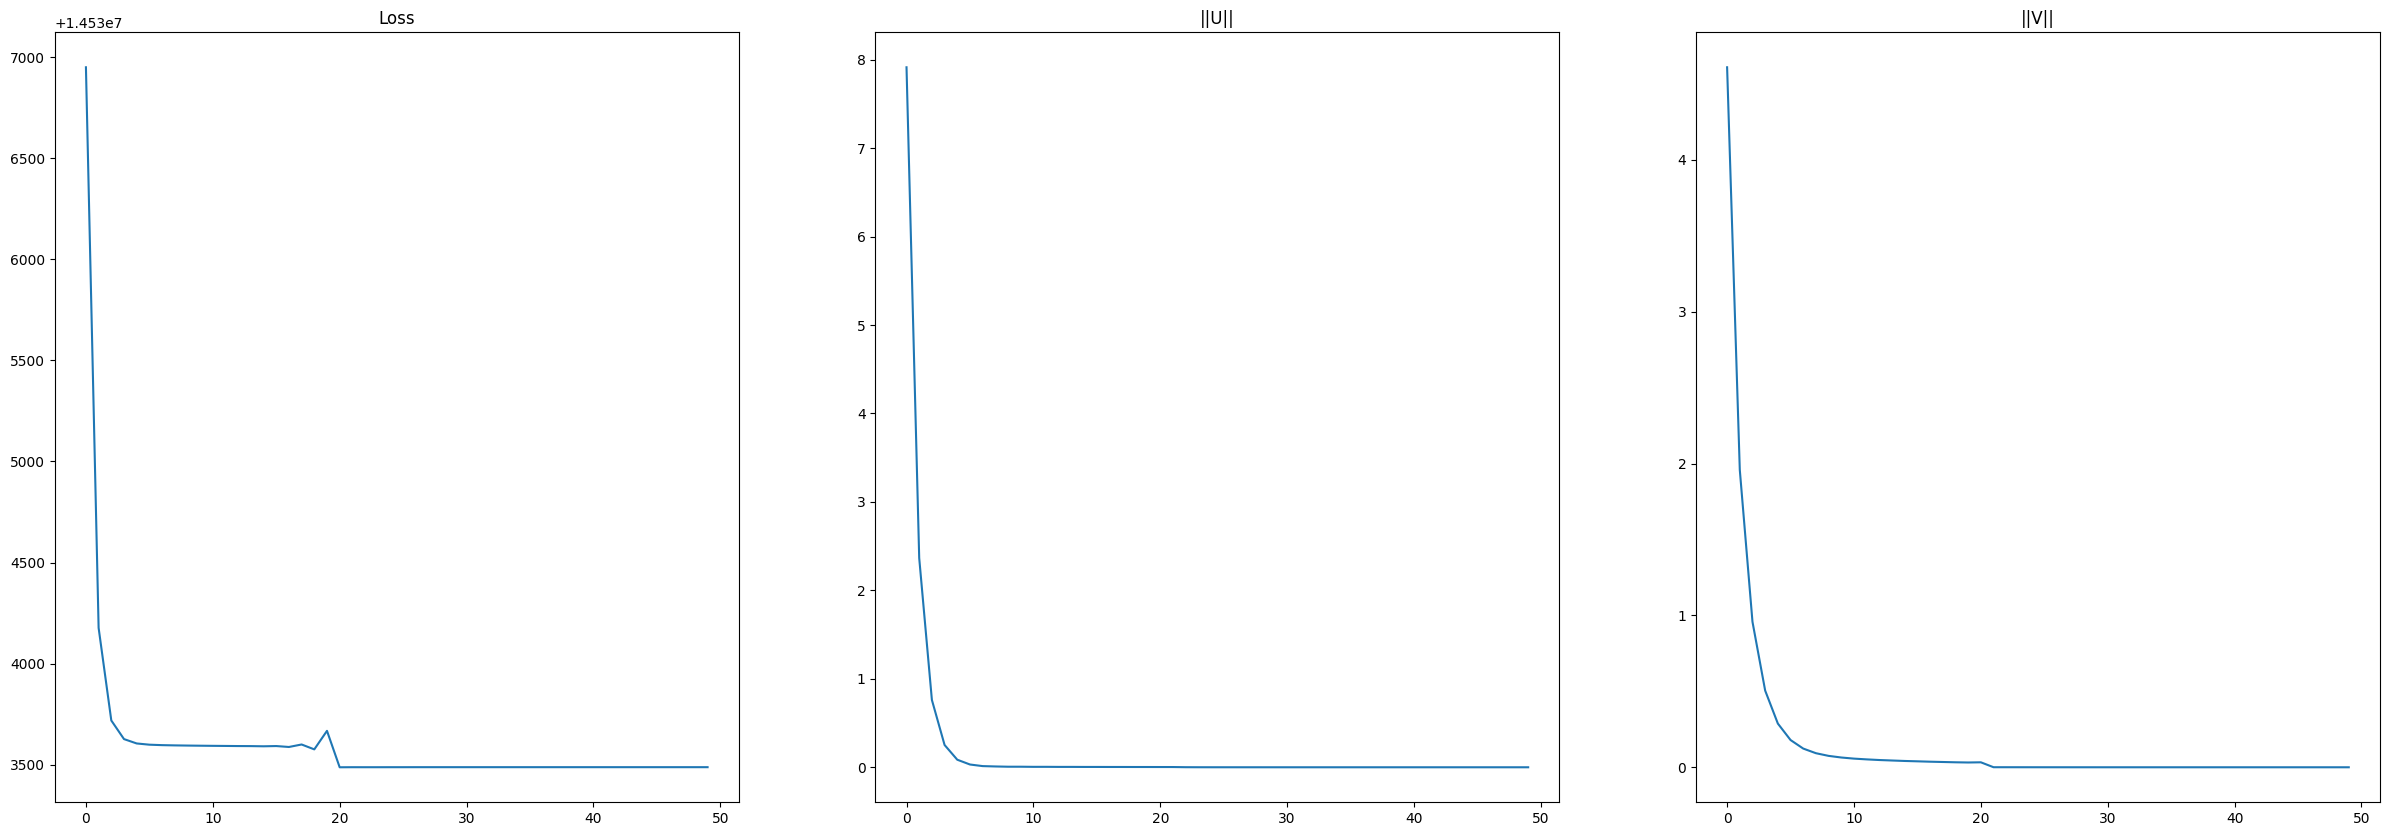

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(30, 10))

axs[0].set_title('Loss')
axs[0].plot(losses)

axs[1].set_title('||U||')
axs[1].plot(U_n)

axs[2].set_title('||V||')
axs[2].plot(V_n)

In [24]:
test_user_inds, U_norms = model.add_unknown_user(test_interations, test_data, n_iters=100, lr=1e-4, batch_size=100) # Add unknown users to user_matrix of our model
preds = model.predict(test_user_inds, np.arange(data_description['n_items'])) # Predict probabilities for unknown users
downvote_seen_items(preds, test_val, data_description)
preds = cp.argsort(preds)[:, -20:].get()

hr, mrr, cov, ndcg = model_evaluate(preds, hold_val, data_description, topn=20) # The score upper the first baseline without choosing hyperparameters for not fully tuned model
print(f'Sigma: {1e-1} \t HR@20: {float(hr):.4f} \t MRR@20: {float(mrr):.4f} \t COV: {float(cov):.4f} \t NDCG@20: {float(ndcg):.4f}')

Sigma: 0.1 	 HR@20: 0.0673 	 MRR@20: 0.0096 	 COV: 0.0638 	 NDCG@20: 0.0214


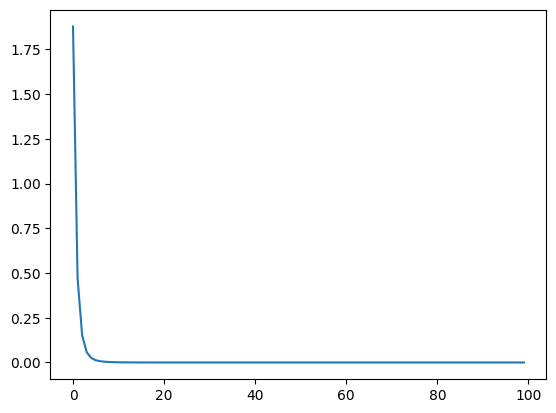

In [25]:
plt.plot(U_norms)

# Hyperparameter tuning

In [110]:
decomp_ranks = (np.arange(10) + 1) * 5

train_interations, train_data = generate_interactions_matrix(train_val, data_description, False, backend=cp)
test_interations, test_data = generate_interactions_matrix(test_val, data_description, True, backend=cp)

results = []

# fig, axs = plt.subplots(1, 3, figsize=(30, 10))

for d in decomp_ranks:

    model = HyperbolicMF(sigma_U=1e-2, sigma_V=1e-2, backend=cp)
    losses, U_n, V_n = model.fit(train_interations, None, num_epochs=50, learning_rate=1e-4, decomposition_rank=d, batch_size=200)

    test_user_inds, U_norms = model.add_unknown_user(test_interations, test_data, n_iters=100, lr=1e-4, batch_size=200) # Add unknown users to user_matrix of our model
    preds = model.predict(test_user_inds, np.arange(data_description['n_items'])) # Predict probabilities for unknown users
    downvote_seen_items(preds, test_val, data_description)
    preds = cp.argsort(preds)[:, -20:].get()

    hr, mrr, cov, ndcg = model_evaluate(preds, hold_val, data_description, topn=20) # The score upper the first baseline without choosing hyperparameters for not fully tuned model
    print(f'Dec rank: {d} \t HR@20: {float(hr):.4f} \t MRR@20: {float(mrr):.4f} \t COV: {float(cov):.4f} \t NDCG@20: {float(ndcg):.4f}')

    results.append((hr, mrr, cov, ndcg))

  0%|          | 0/50 [00:00<?, ?it/s]

Dec rank: 5 	 HR@20: 0.1035 	 MRR@20: 0.0164 	 COV: 0.0668 	 NDCG@20: 0.0343


  0%|          | 0/50 [00:00<?, ?it/s]

Dec rank: 10 	 HR@20: 0.1060 	 MRR@20: 0.0157 	 COV: 0.0665 	 NDCG@20: 0.0343


  0%|          | 0/50 [00:00<?, ?it/s]

Dec rank: 15 	 HR@20: 0.1060 	 MRR@20: 0.0159 	 COV: 0.0665 	 NDCG@20: 0.0344


  0%|          | 0/50 [00:00<?, ?it/s]

Dec rank: 20 	 HR@20: 0.1060 	 MRR@20: 0.0157 	 COV: 0.0709 	 NDCG@20: 0.0343


  0%|          | 0/50 [00:00<?, ?it/s]

Dec rank: 25 	 HR@20: 0.1060 	 MRR@20: 0.0159 	 COV: 0.0665 	 NDCG@20: 0.0344


  0%|          | 0/50 [00:00<?, ?it/s]

Dec rank: 30 	 HR@20: 0.1060 	 MRR@20: 0.0159 	 COV: 0.0665 	 NDCG@20: 0.0344


  0%|          | 0/50 [00:00<?, ?it/s]

Dec rank: 35 	 HR@20: 0.1060 	 MRR@20: 0.0157 	 COV: 0.0709 	 NDCG@20: 0.0343


  0%|          | 0/50 [00:00<?, ?it/s]

Dec rank: 40 	 HR@20: 0.1035 	 MRR@20: 0.0164 	 COV: 0.0712 	 NDCG@20: 0.0343


  0%|          | 0/50 [00:00<?, ?it/s]

Dec rank: 45 	 HR@20: 0.1035 	 MRR@20: 0.0164 	 COV: 0.0712 	 NDCG@20: 0.0343


  0%|          | 0/50 [00:00<?, ?it/s]

Dec rank: 50 	 HR@20: 0.1035 	 MRR@20: 0.0166 	 COV: 0.0712 	 NDCG@20: 0.0345


# SSVD

In [54]:
from scipy.sparse.linalg import svds

def rescale_matrix(matrix, scale_factor):
    freqs = matrix.getnnz(axis=0)
    mean_rating = matrix.sum(axis=1) / matrix.getnnz(axis=1).reshape((-1, 1))
    scaling_freqs = np.power(freqs, 0.5 * (scale_factor - 1))
    scaling_rating = np.power(mean_rating, 0.5 * (scale_factor - 1))
    return matrix.multiply(scaling_freqs).multiply(scaling_rating), (scaling_freqs, scaling_rating)

def build_ssvd_model(config, data, data_description):
    _, source_matrix = generate_interactions_matrix(data, data_description, rebase_users=False)
    # scaled_matrix, scale_weights = rescale_matrix(source_matrix, config['scaling'])
    # scaled_matrix, scale_weights = rescale_matrix(source_matrix, config['scaling'])
    _, _, vt = svds(source_matrix, k=config['rank'], return_singular_vectors='vh')
    # singular_values = s[::-1]
    item_factors = np.ascontiguousarray(vt[::-1, :].T)
    return item_factors#, scale_weights

def ssvd_scoring(item_factor_trunc, testset, data_description):
    _, matrix = generate_interactions_matrix(testset, data_description, rebase_users=True)
    scores = (matrix @ item_factor_trunc) @ item_factor_trunc.T
    downvote_seen_items(scores, testset, data_description)
    return scores

def ssvd_grid_search(ranks, scalings, training, testset, holdout, data_description, topn=20):
    max_rank = max(ranks)
    results = {}
    for scaling in scalings:
        # config = {'rank': max_rank, 'scaling': scaling}
        config = {'rank': max_rank, 'scaling': scaling}
        item_factors = build_ssvd_model(config, training, data_description)
        for rank in ranks:
            # config = {'rank': rank, 'scaling': scaling}
            item_factor_trunc = item_factors[:, :rank]
            scores = ssvd_scoring(item_factor_trunc, testset, data_description)
            recs = cp.argsort(scores)[:, -20:]#topn_recommendations(scores, topn-topn)
            results[(rank, scaling)] = model_evaluate(recs, holdout, data_description)
    return results

In [56]:
results_ssvd = ssvd_grid_search(decomp_ranks, [0], train_val, test_val, hold_val, data_description)

Text(0.5, 0, 'Decomposition rank')

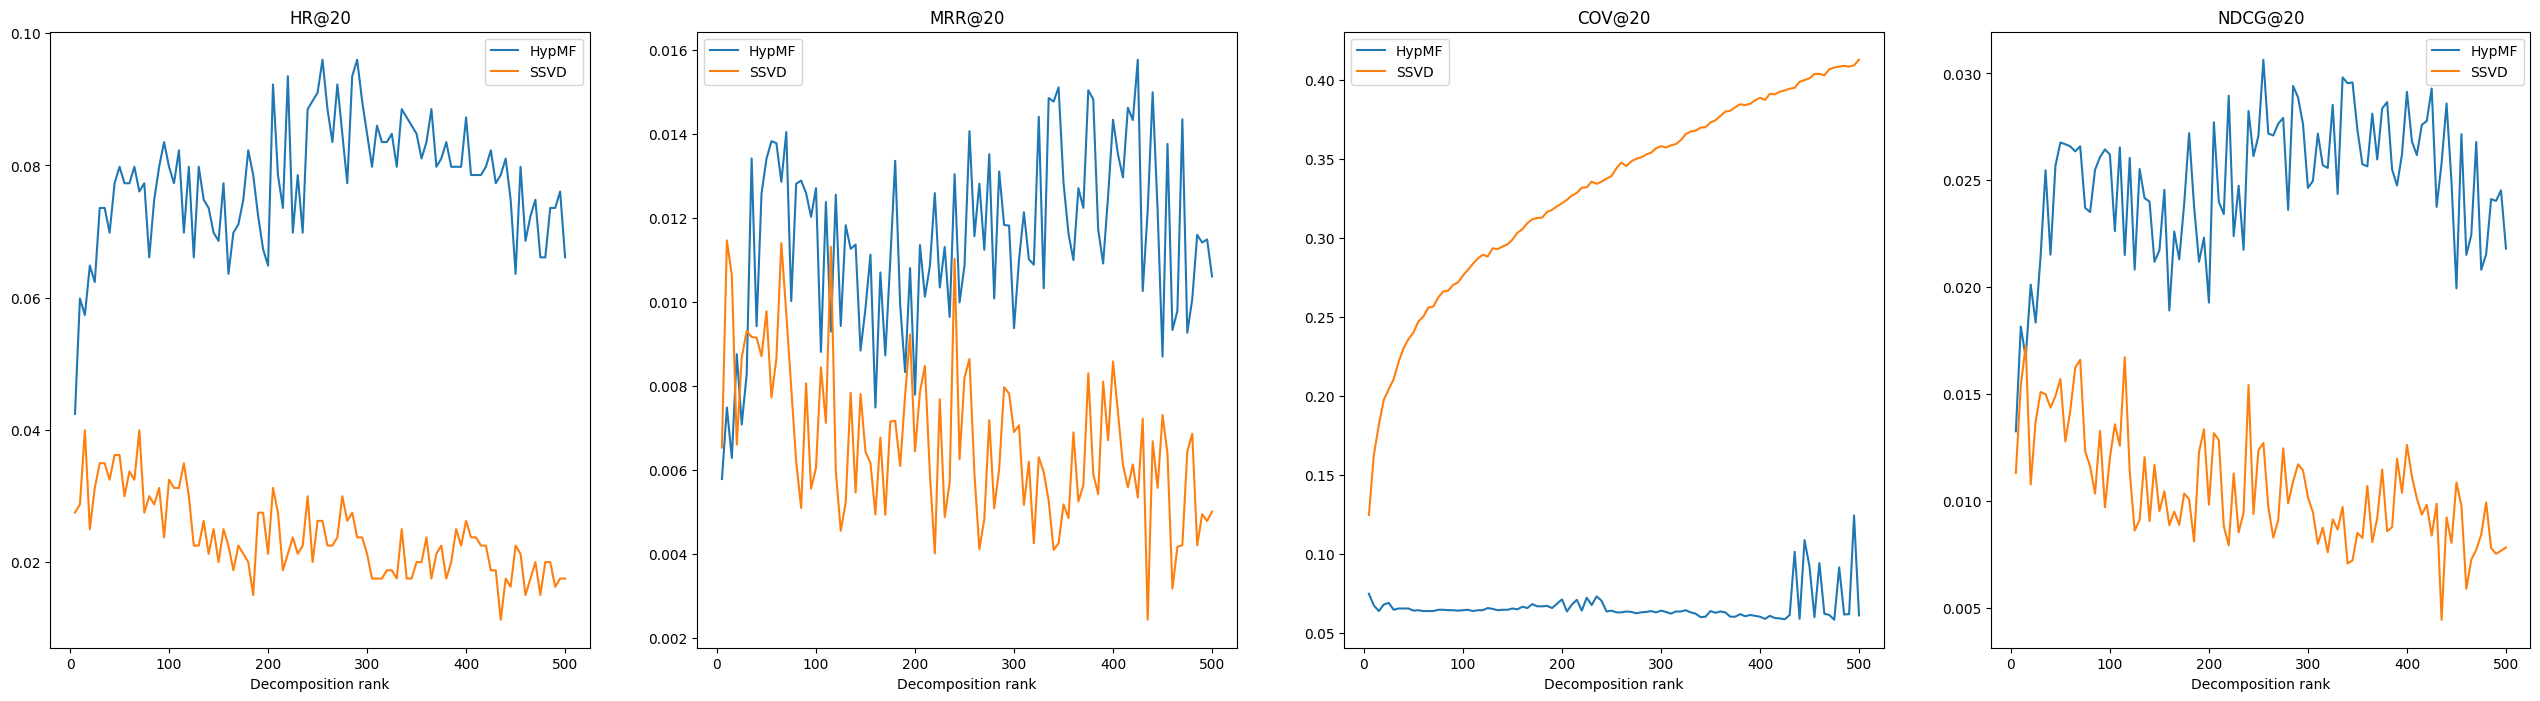

In [65]:
fig, axs = plt.subplots(1, 4, figsize=(32, 8))
results = np.array(results)

axs[0].plot(decomp_ranks, results[:, 0], label='HypMF')
axs[0].plot(decomp_ranks, [results_ssvd[(i, 0)][0] for i in decomp_ranks], label='SSVD')
axs[0].set_title('HR@20')
axs[0].legend()
axs[0].set_xlabel('Decomposition rank')

axs[1].plot(decomp_ranks, results[:, 1], label='HypMF')
axs[1].plot(decomp_ranks, [results_ssvd[(i, 0)][1] for i in decomp_ranks], label='SSVD')
axs[1].set_title('MRR@20')
axs[1].legend()
axs[1].set_xlabel('Decomposition rank')

axs[2].plot(decomp_ranks, results[:, 2], label='HypMF')
axs[2].plot(decomp_ranks, [results_ssvd[(i, 0)][2] for i in decomp_ranks], label='SSVD')
axs[2].set_title('COV@20')
axs[2].legend()
axs[2].set_xlabel('Decomposition rank')

axs[3].plot(decomp_ranks, results[:, 3], label='HypMF')
axs[3].plot(decomp_ranks, [results_ssvd[(i, 0)][3] for i in decomp_ranks], label='SSVD')
axs[3].set_title('NDCG@20')
axs[3].legend()
axs[3].set_xlabel('Decomposition rank')

# Check predictions of the best model

In [31]:
a = np.array([0, 1, 2])
b = np.array([3, 4, 5])
A, B = np.meshgrid(a, b)
A.reshape(-1), B.reshape(-1)

(array([0, 1, 2, 0, 1, 2, 0, 1, 2]), array([3, 3, 3, 4, 4, 4, 5, 5, 5]))

In [104]:
train_interations, train_data = generate_interactions_matrix(train_val, data_description, False, backend=cp)
test_interations, test_data = generate_interactions_matrix(test_val, data_description, True, backend=cp)

model = HyperbolicMF(sigma_U=1e-2, sigma_V=1e-2, backend=cp)
losses, U_n, V_n = model.fit(train_interations, train_data, num_epochs=50, learning_rate=1e-4, decomposition_rank=50, batch_size=200)

test_user_inds, U_norms = model.add_unknown_user(test_interations, test_data, n_iters=100, lr=1e-4, batch_size=200) # Add unknown users to user_matrix of our model
preds = model.predict(test_user_inds, np.arange(data_description['n_items'])) # Predict probabilities for unknown users
downvote_seen_items(preds, test_val, data_description)
preds = cp.argsort(preds)[:, -20:].get()

  0%|          | 0/50 [00:00<?, ?it/s]

98055.50786345673
98792.4202472004
6977.6887636413
----------------------------------------------------------------------------------------------------
98684.85317362346
99428.4023579971
7032.6373948455275
----------------------------------------------------------------------------------------------------
98669.81356044655
99411.12932488436
7021.9335814137075
----------------------------------------------------------------------------------------------------
98789.28716327171
99517.33992357003
6962.419379764787
----------------------------------------------------------------------------------------------------
99222.05481682126
99943.4811616395
6944.265256734145
----------------------------------------------------------------------------------------------------
97586.73139276962
98311.24214772655
6902.458556631627
----------------------------------------------------------------------------------------------------
100603.33340606802
101348.74402354618
7109.0569348631425
----------------

In [98]:
hr, mrr, cov, ndcg = model_evaluate(preds, hold_val, data_description, topn=20) # The score upper the first baseline without choosing hyperparameters for not fully tuned model
print(f'Dec rank: {0} \t HR@20: {float(hr):.4f} \t MRR@20: {float(mrr):.4f} \t COV: {float(cov):.4f} \t NDCG@20: {float(ndcg):.4f}')

Dec rank: 0 	 HR@20: 0.0925 	 MRR@20: 0.0181 	 COV: 0.0765 	 NDCG@20: 0.0335


In [99]:
users = np.where((preds == hold_val['movieid'].values.reshape(-1, 1)).sum(axis=1) > 0)[0]

In [100]:
ids = preds[preds == hold_val['movieid'].values.reshape(-1, 1)]

In [101]:
model.predict(np.arange(20), np.arange(20)).max(axis=1)

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

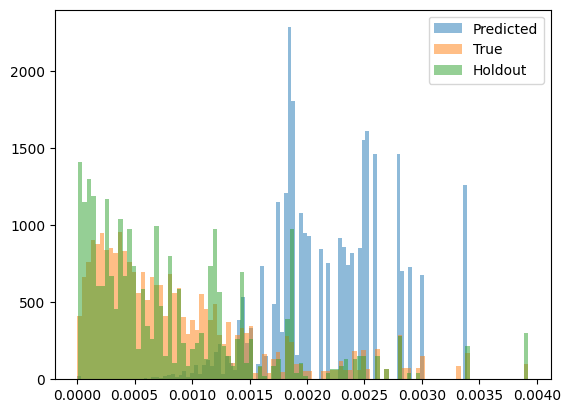

In [61]:
preds_r = preds.ravel()
freq_preds = []
freqs = {}
for p in preds_r:
    if p in freqs:
        freq_preds.append(freqs[p])
    else:
        f = (train_val['movieid'] == p).sum() / len(train_val)
        freqs[p] = f
        freq_preds.append(f)
plt.hist(np.array(freq_preds).ravel(), bins=100, density=True, label='Predicted', alpha=0.5)

freq_train = []
freqs = {}
for p in train_val['movieid']:
    if p in freqs:
        freq_train.append(freqs[p])
    else:
        f = (train_val['movieid'] == p).sum() / len(train_val)
        freqs[p] = f
        freq_train.append(f)
plt.hist(np.array(freq_train).ravel(), bins=100, density=True, label='True', alpha=0.5)
plt.legend()

freq_train = []
freqs = {}
for p in hold_val['movieid']:
    if p in freqs:
        freq_train.append(freqs[p])
    else:
        f = (train_val['movieid'] == p).sum() / len(train_val)
        freqs[p] = f
        freq_train.append(f)
plt.hist(np.array(freq_train).ravel(), bins=100, density=True, label='Holdout', alpha=0.5)
plt.legend()

In [57]:
item_factors = build_ssvd_model({'rank': 35, 'scaling': 0}, train_val, data_description)
item_factor_trunc = item_factors[:, :35]
scores = ssvd_scoring(item_factor_trunc, test_val, data_description)
recs = cp.argsort(scores)[:, -20:]

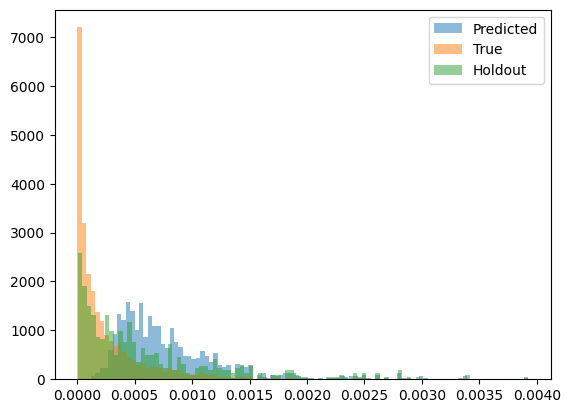

In [59]:
freq_preds = []
freqs = {}
for p in np.unique(recs.ravel()):
    if p in freqs:
        freq_preds.append(freqs[p])
    else:
        f = (train_val['movieid'] == p).sum() / len(train_val)
        freqs[p] = f
        freq_preds.append(f)
plt.hist(np.array(freq_preds).ravel(), bins=100, density=True, label='Predicted', alpha=0.5)

freq_train = []
freqs = {}
for p in train_val['movieid'].unique():
    if p in freqs:
        freq_train.append(freqs[p])
    else:
        f = (train_val['movieid'] == p).sum() / len(train_val)
        freqs[p] = f
        freq_train.append(f)
plt.hist(np.array(freq_train).ravel(), bins=100, density=True, label='True', alpha=0.5)
plt.legend()

freq_train = []
freqs = {}
for p in hold_val['movieid'].unique():
    if p in freqs:
        freq_train.append(freqs[p])
    else:
        f = (train_val['movieid'] == p).sum() / len(train_val)
        freqs[p] = f
        freq_train.append(f)
plt.hist(np.array(freq_train).ravel(), bins=100, density=True, label='Holdout', alpha=0.5)
plt.legend()

In [ ]:
freq_preds = []
freqs = {}
for pred in train_val['movieid']:
    freq_preds.append([])
    for p in pred:
        if p in freqs:
            freq_preds[-1].append(freqs[p])
        else:
            f = (train_val['movieid'] == p).sum() / len(train_val)
            freqs[p] = f
            freq_preds[-1].append(f)
plt.hist(np.array(freq_preds).ravel())

In [73]:
n_bins = len(np.unique(preds.ravel()))

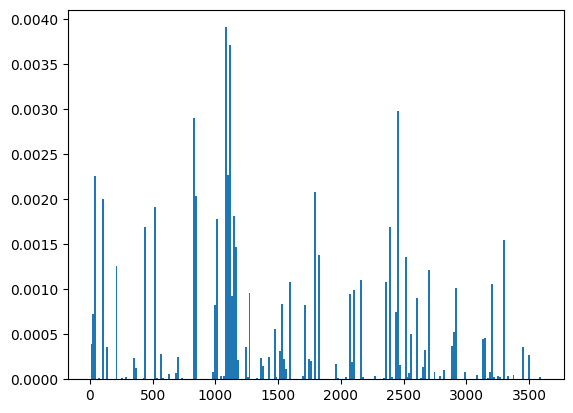

In [92]:
_ = plt.hist(preds.ravel(), bins=n_bins, density=True)

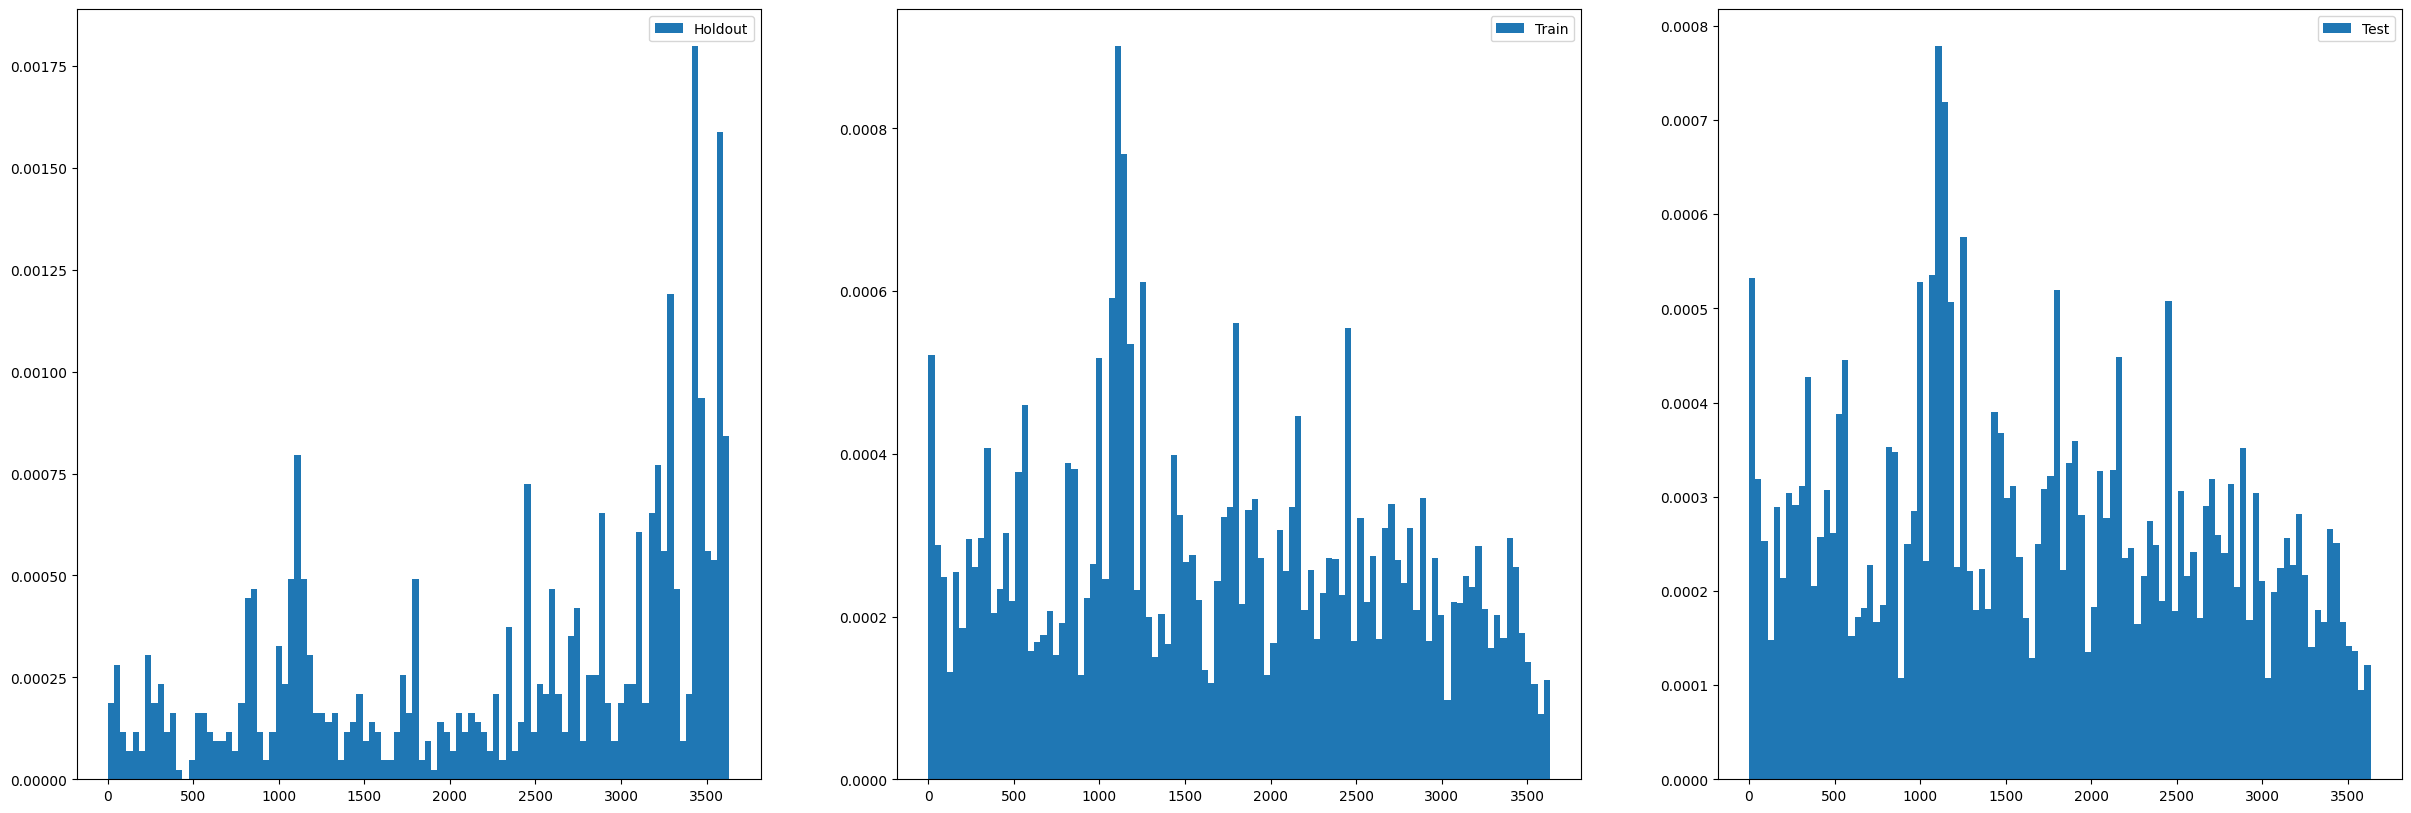

In [15]:
fix, axs = plt.subplots(1, 3, figsize=(30, 10))

axs[0].hist(hold_val['movieid'], bins=100, density=True, label='Holdout')
axs[0].legend()
axs[1].hist(train_val['movieid'], bins=100, density=True, label='Train')
axs[1].legend()
axs[2].hist(test_val['movieid'], bins=100, density=True, label='Test')
axs[2].legend()

In [95]:
np.unique(hold_val['movieid']).size / data_description['n_items']

0.13362541073384446

In [98]:
item_factors = build_ssvd_model({'rank': 35, 'scaling': 0}, train_val, data_description)
item_factor_trunc = item_factors[:, :35]
scores = ssvd_scoring(item_factor_trunc, test_val, data_description)
recs = cp.argsort(scores)[:, -20:]#topn_recommendations(scores, topn-topn)
# results[(rank, scaling)] = model_evaluate(recs, holdout, data_description)

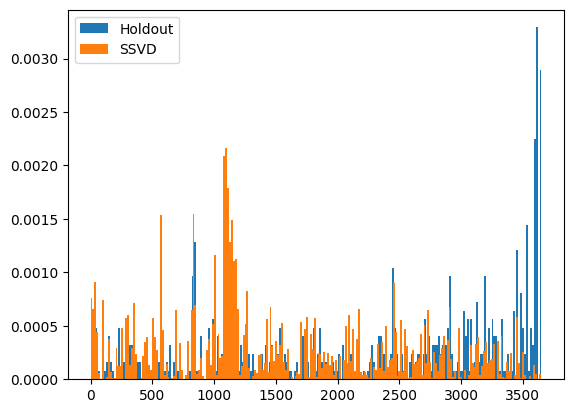

In [108]:
_ = plt.hist(hold_val['movieid'], bins=n_bins, density=True, label='Holdout')
_ = plt.hist(recs.ravel(), bins=n_bins, density=True, label='SSVD')
plt.legend()

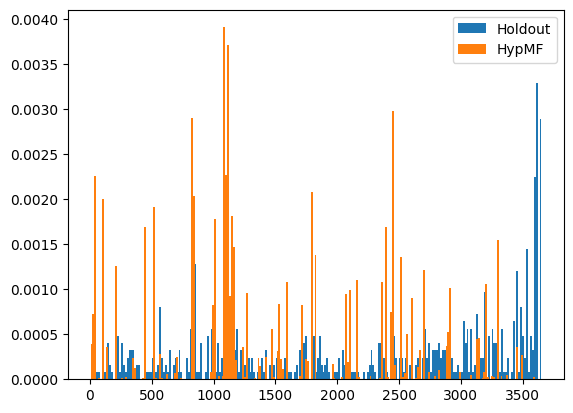

In [109]:
_ = plt.hist(hold_val['movieid'], bins=n_bins, density=True, label='Holdout')
_ = plt.hist(preds.ravel(), bins=n_bins, density=True, label='HypMF')
plt.legend()

In [ ]:
np.unique(recs.ravel()).size / data_description['n_items']

In [ ]:
np.unique(preds.ravel()).size / data_description['n_items']

# Stochastic training of Hyperbolic MF

In [10]:
train_val

,userid,movieid,rating,timestamp
0,0,1084,5.0,978300760
1,0,631,3.0,978302109
2,0,835,3.0,978301968
3,0,3129,4.0,978300275
4,0,2126,5.0,978824291
...,...,...,...,...
999863,5226,991,4.0,956705989
999864,5226,993,3.0,956706051
999865,5226,996,4.0,956706182
999866,5226,998,4.0,956706019


In [39]:
# train_interations, train_data = generate_interactions_matrix(train_val, data_description, False, backend=cp)
# test_interations, test_data = generate_interactions_matrix(test_val, data_description, True, backend=cp)

cp.random.seed(42)
np.random.seed(42)

neg_ss = np.linspace(1, 20, 20).astype(np.int16)
res = []

for s in neg_ss:

    model = HyperbolicMF(sigma_U=1e-2, sigma_V=1e-2, backend=cp)
    sampler = NegativeSampler(train_val, data_description, neg_samples_multiplier=s, rebase_users=False)
    losses, U_n, V_n = model.fit_stochastic(sampler, num_iters=500, learning_rate=1e-4, decomposition_rank=5, batch_size=1000)

    test_sampler = NegativeSampler(test_val, data_description, rebase_users=True)
    test_user_inds, U_norms = model.add_unknown_user_stochastic(test_sampler, n_iters=500, lr=1e-4, batch_size=2000) # Add unknown users to user_matrix of our model
    preds = model.predict(test_user_inds, np.arange(data_description['n_items'])) # Predict probabilities for unknown users
    downvote_seen_items(preds, test_val, data_description)
    preds = cp.argsort(preds)[:, -20:].get()

    hr, mrr, cov, ndcg = model_evaluate(preds, hold_val, data_description, topn=20)
    print(f'Neg mult: {s} \t HR@20: {float(hr):.4f} \t MRR@20: {float(mrr):.4f} \t COV@20: {float(cov):.4f} \t NDCG@20: {float(ndcg):.4f}')
    res.append((hr, mrr, cov, ndcg))

  0%|          | 0/500 [00:00<?, ?it/s]

Neg mult: 1 	 HR@20: 0.0586 	 MRR@20: 0.0074 	 COV@20: 0.0435 	 NDCG@20: 0.0179


  0%|          | 0/500 [00:00<?, ?it/s]

Neg mult: 2 	 HR@20: 0.0857 	 MRR@20: 0.0099 	 COV@20: 0.0446 	 NDCG@20: 0.0251


  0%|          | 0/500 [00:00<?, ?it/s]

Neg mult: 3 	 HR@20: 0.0586 	 MRR@20: 0.0098 	 COV@20: 0.0459 	 NDCG@20: 0.0201


  0%|          | 0/500 [00:00<?, ?it/s]

Neg mult: 4 	 HR@20: 0.0806 	 MRR@20: 0.0127 	 COV@20: 0.0399 	 NDCG@20: 0.0265


  0%|          | 0/500 [00:00<?, ?it/s]

Neg mult: 5 	 HR@20: 0.0985 	 MRR@20: 0.0154 	 COV@20: 0.0446 	 NDCG@20: 0.0324


  0%|          | 0/500 [00:00<?, ?it/s]

Neg mult: 6 	 HR@20: 0.0951 	 MRR@20: 0.0133 	 COV@20: 0.0327 	 NDCG@20: 0.0305


  0%|          | 0/500 [00:00<?, ?it/s]

Neg mult: 7 	 HR@20: 0.1061 	 MRR@20: 0.0155 	 COV@20: 0.0286 	 NDCG@20: 0.0345


  0%|          | 0/500 [00:00<?, ?it/s]

Neg mult: 8 	 HR@20: 0.0908 	 MRR@20: 0.0093 	 COV@20: 0.0195 	 NDCG@20: 0.0254


  0%|          | 0/500 [00:00<?, ?it/s]

Neg mult: 9 	 HR@20: 0.0577 	 MRR@20: 0.0060 	 COV@20: 0.0176 	 NDCG@20: 0.0164


  0%|          | 0/500 [00:00<?, ?it/s]

Neg mult: 10 	 HR@20: 0.0467 	 MRR@20: 0.0066 	 COV@20: 0.0490 	 NDCG@20: 0.0149


  0%|          | 0/500 [00:00<?, ?it/s]

Neg mult: 11 	 HR@20: 0.0679 	 MRR@20: 0.0064 	 COV@20: 0.0182 	 NDCG@20: 0.0187


  0%|          | 0/500 [00:00<?, ?it/s]

Neg mult: 12 	 HR@20: 0.0594 	 MRR@20: 0.0070 	 COV@20: 0.0138 	 NDCG@20: 0.0177


  0%|          | 0/500 [00:00<?, ?it/s]

Neg mult: 13 	 HR@20: 0.0535 	 MRR@20: 0.0089 	 COV@20: 0.0209 	 NDCG@20: 0.0181


  0%|          | 0/500 [00:00<?, ?it/s]

Neg mult: 14 	 HR@20: 0.0467 	 MRR@20: 0.0049 	 COV@20: 0.0380 	 NDCG@20: 0.0133


  0%|          | 0/500 [00:00<?, ?it/s]

Neg mult: 15 	 HR@20: 0.0492 	 MRR@20: 0.0055 	 COV@20: 0.0374 	 NDCG@20: 0.0143


  0%|          | 0/500 [00:00<?, ?it/s]

Neg mult: 16 	 HR@20: 0.0441 	 MRR@20: 0.0039 	 COV@20: 0.0129 	 NDCG@20: 0.0121


  0%|          | 0/500 [00:00<?, ?it/s]

Neg mult: 17 	 HR@20: 0.0552 	 MRR@20: 0.0051 	 COV@20: 0.0140 	 NDCG@20: 0.0152


  0%|          | 0/500 [00:00<?, ?it/s]

Neg mult: 18 	 HR@20: 0.0569 	 MRR@20: 0.0047 	 COV@20: 0.0124 	 NDCG@20: 0.0152


  0%|          | 0/500 [00:00<?, ?it/s]

Neg mult: 19 	 HR@20: 0.0637 	 MRR@20: 0.0092 	 COV@20: 0.0138 	 NDCG@20: 0.0203


  0%|          | 0/500 [00:00<?, ?it/s]

Neg mult: 20 	 HR@20: 0.0577 	 MRR@20: 0.0058 	 COV@20: 0.0129 	 NDCG@20: 0.0164


Text(0.5, 0, 'Negative samples multiplier')

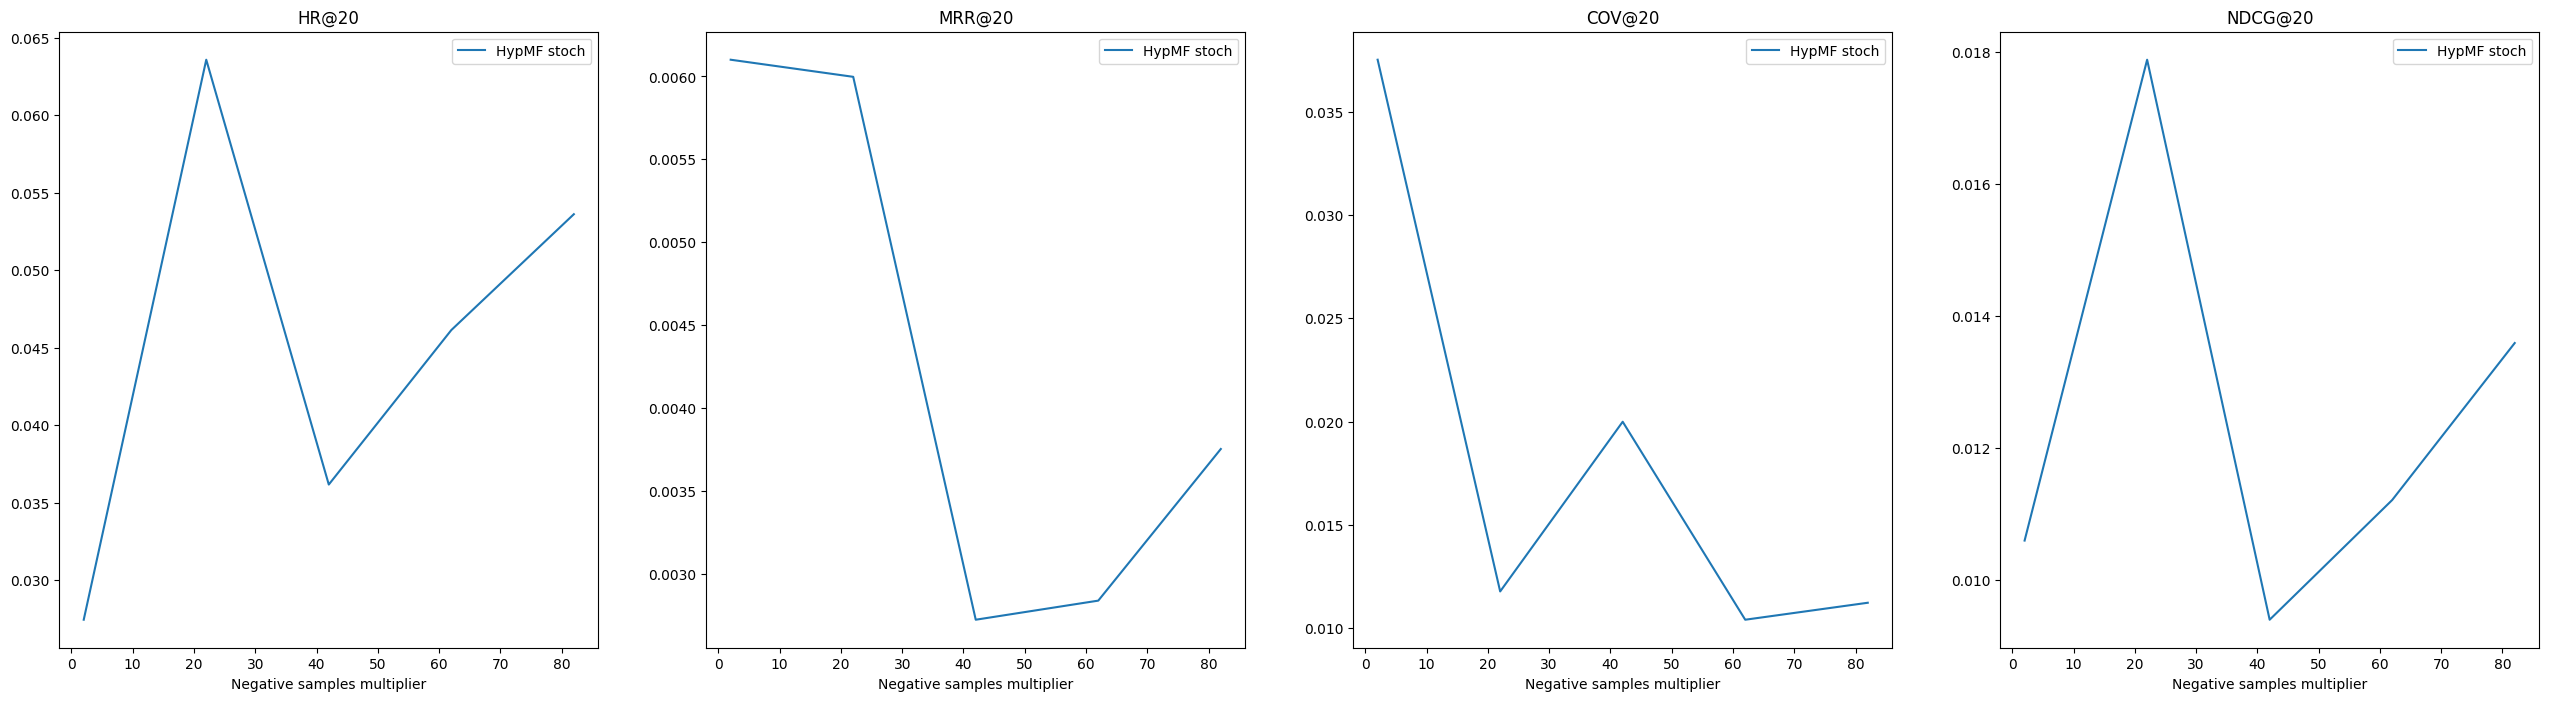

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(32, 8))
results = np.array(res)

axs[0].plot(neg_ss, results[:, 0], label='HypMF stoch')
# axs[0].plot(decomp_ranks, [results_ssvd[(i, 0)][0] for i in decomp_ranks], label='SSVD')
axs[0].set_title('HR@20')
axs[0].legend()
axs[0].set_xlabel('Negative samples multiplier')

axs[1].plot(neg_ss, results[:, 1], label='HypMF stoch')
# axs[1].plot(decomp_ranks, [results_ssvd[(i, 0)][1] for i in decomp_ranks], label='SSVD')
axs[1].set_title('MRR@20')
axs[1].legend()
axs[1].set_xlabel('Negative samples multiplier')

axs[2].plot(neg_ss, results[:, 2], label='HypMF stoch')
# axs[2].plot(decomp_ranks, [results_ssvd[(i, 0)][2] for i in decomp_ranks], label='SSVD')
axs[2].set_title('COV@20')
axs[2].legend()
axs[2].set_xlabel('Negative samples multiplier')

axs[3].plot(neg_ss, results[:, 3], label='HypMF stoch')
# axs[3].plot(decomp_ranks, [results_ssvd[(i, 0)][3] for i in decomp_ranks], label='SSVD')
axs[3].set_title('NDCG@20')
axs[3].legend()
axs[3].set_xlabel('Negative samples multiplier')

In [59]:
test_sampler = NegativeSampler(test_val, data_description, rebase_users=True)
test_user_inds, U_norms = model.add_unknown_user_stochastic(test_sampler, n_iters=1000, lr=1e-4, batch_size=200) # Add unknown users to user_matrix of our model
preds = model.predict(test_user_inds, np.arange(data_description['n_items'])) # Predict probabilities for unknown users
downvote_seen_items(preds, test_val, data_description)
preds = cp.argsort(preds)[:, -20:].get()

In [60]:
hr, mrr, cov, ndcg = model_evaluate(preds, hold_val, data_description, topn=20) # The score upper the first baseline without choosing hyperparameters for not fully tuned model
print(f'Dec rank: {20} \t HR@20: {float(hr):.4f} \t MRR@20: {float(mrr):.4f} \t COV: {float(cov):.4f} \t NDCG@20: {float(ndcg):.4f}')

Dec rank: 20 	 HR@20: 0.0411 	 MRR@20: 0.0104 	 COV: 0.0126 	 NDCG@20: 0.0172
